#  Plotting the Correlation vs GPS Time Dataframe results

**Paolo Marcoccia<sup>1</sup>, Felicia Frederiksson<sup>2</sup>, Alex B. Nielsen<sup>1</sup> and Germano Nardini<sup>1</sup>**

<sub>1. University of Stavanger, Institutt for Matematikk og Fysikk, Kjølv Egelands hus, 5.etg, E-blokk, 4021 Stavanger, Norway </sub> <br>
<sub>2. University of Uppsala, Department of Physics and Astronomy,Ångströmlaboratoriet, Lägerhyddsvägen 1, 751 20 Uppsala, Sweden</sub> 

We encourage use of these data in derivative works. If you use the material provided here, please cite [our paper.]()

In this notebook, we will learn how to plot the [CorrVsTime.csv](https://github.com/GravWaves-IMF/Correlation-Method-first-2019-/blob/master/Code/GW150914/CorrVsTime.csv) dataframe, containing the Correlation vs GPS Time for the analyzed events, in order to obtain the [GW*event-name*CorrVsTime.png](https://github.com/GravWaves-IMF/Correlation-Method-first-2019-/blob/master/Code/GW150914/GW150914CorrVsTime.png) plot.
In order to run this pipeline, however, you need the _residuals.hdf_ file generated by running the [CreateResiduals.ipynb](https://github.com/gwastro/gw150914_investigation/blob/master/CreateResiduals.ipynb) notebook, and the [CorrVsTime.csv](https://github.com/GravWaves-IMF/Correlation-Method-first-2019-/blob/master/Code/GW150914/CorrVsTime.csv) dataframe obtained by running the [CorrVsTime.ipynb](https://github.com/GravWaves-IMF/Correlation-Method-first-2019-/blob/master/Code/CorrVsTime.ipynb).
From the [Code](https://github.com/GravWaves-IMF/Correlation-Method-first-2019-/blob/master/Code) directory, let's start by loading the modules :

In [1]:
%run init_module.py

Let's also run the [BigFont.py](https://github.com/GravWaves-IMF/Correlation-Method-first-2019-/blob/master/Code/BigFont.py) script in order to increase the font size of the plot.
The setting, may be easily changed from the previous file in order to personalize the final output of this notebook.

In [2]:
%run BigFont.py

We may finally move to the directory of the event we wish to plot :

In [3]:
%cd GW150914/
#%cd GW151012/
#%cd GW151226/
#%cd GW170104/

/home/kuza91/Documents/IPyNB/GWO1/GW150914


as usual, the data setting for the choosed event may be initialized by running :

In [4]:
%run GW150914data.py
#%run GW151012data.py
#%run GW151226data.py
#%run GW170104data.py

('segment length:', 16)


and let's also initialize some auxiliary array :

In [5]:
data, psd_data, ts, ts3, waveforms, psds = {},{},{},{}, {},{}

We may finally start to load the data needed for the plot, as stated in the **Additional information** section of the [README.md](https://github.com/GravWaves-IMF/Correlation-Method-first-2019-/blob/master/README.md), we will load the detector strain using the auxiliary variables defined in [GW*event-name*data.py](https://github.com/GravWaves-IMF/Correlation-Method-first-2019-/blob/master/Code/GW150914/GW150914data.py) by running :

In [6]:
data_files = {'H1': 'H-H1_' + hd_nm ,
              'L1': 'L-L1_' + hd_nm}

Remember that the file names may change according to how old is the data you are using for this analysis!    
Let's keep on by cutting a clean dataset from the strain and a highpassed dataset for the _PSD_ data :

In [7]:
for ifo, fn in data_files.items():
        
        # In the case of GW150914, the strain channel are called as LOSC-STRAIN
        
        psd_data[ifo] = frame.read_frame(fn, '{}:LOSC-STRAIN'.format(ifo),
                                         start_time=psd_start_time-pad_data,
                                         end_time=psd_end_time+pad_data)
        
        # For all the others event, use this setup
        
        #psd_data[ifo] = frame.read_frame(fn, '{}:GWOSC-4KHZ_R1_STRAIN'.format(ifo),
        #                                 start_time=psd_start_time-pad_data,
        #                                 end_time=psd_end_time+pad_data)        

In [8]:
for ifo,d in psd_data.items():
        d = filter.highpass(d, fhighpass)
        psd_data[ifo] = d.time_slice(psd_start_time, psd_end_time)

In [9]:
for ifo, fn in data_files.items():
        
        # Same as In[7], need to cut down the data for GW151226 due to nan at the start of the time series
        
        # Used for GW150914
        
        data[ifo] = frame.read_frame(fn, '{}:LOSC-STRAIN'.format(ifo)) 
        
        # Used for GW151226 to avoid the nan at the beginning of the dataframe
        
        #data[ifo] = frame.read_frame(fn, '{}:GWOSC-4KHZ_R1_STRAIN'.format(ifo),
        #                              start_time=psd_start_time-pad_data, end_time=psd_end_time+pad_data)
        
        # Used for the other 2 events
        
        #data[ifo] = frame.read_frame(fn, '{}:GWOSC-4KHZ_R1_STRAIN'.format(ifo))

For the event _GW151226_, you would need to add the 'start_time' and 'end_time' label as stated in the **Additional information** section of the [README.md](https://github.com/GravWaves-IMF/Correlation-Method-first-2019-/blob/master/README.md), in order to avoid the _NULL_ data at the start of the dataset.        
We may now load the data for the _Maximum Likelihood_ posteriors :

In [10]:
fp = InferenceFile(pst_nm, 'r')
variable_args = fp.attrs['variable_args']
static_args = {'approximant': 'IMRPhenomPv2',
                    'f_lower': 10.0,
                    'f_ref': 20.0}
samples = fp.read_samples(variable_args)
posterior_stats = fp.read_likelihood_stats()
maxLpt= posterior_stats['loglr'].argmax()
maxLR = posterior_stats['loglr'][maxLpt]
maxL_params = samples[maxLpt]

Let's generate the _PSD_ for the event by running :

In [11]:
for ifo, d in psd_data.items():
         psd = pypsd.welch(d, seg_len=psd_seg_len*sample_rate, 
               seg_stride=psd_seg_stride*sample_rate)
         # truncate
         psd = pypsd.inverse_spectrum_truncation(psd, 
               inverse_psd_len*sample_rate, low_frequency_cutoff=15.)
         # interpolate to needed df
         psd = pypsd.interpolate(psd, data['H1'].delta_f)
         psds[ifo] = psd

and following the notebook of [Nielsen et al.](https://github.com/gwastro/gw150914_investigation), we'll set the maximum frequency of the low-pass filter at _1024 Hz_ :   

In [12]:
filter_fmax = 1024.

We now have got everything we need to generate the waveforms for the strain data :

In [13]:
generator = FDomainDetFrameGenerator(FDomainCBCGenerator, 
            data['H1'].start_time, detectors=data.keys(),
            variable_args=variable_args, 
            delta_f=data['H1'].delta_f, **static_args)

htildes = generator.generate(**{p: maxL_params[p] for p in variable_args})

however, we need to find the phase offset for the generated waves in order to match them with the strain data, it may be done by running :

In [14]:
cplx_hd = 0j
hh = 0.
for ifo,d in data.items():
         htilde = htildes[ifo]
         dtilde = d.to_frequencyseries()
         htilde.resize(len(dtilde))
         cplx_hd += filter.overlap_cplx(htilde, dtilde, psd=psds[ifo], 
                    low_frequency_cutoff=filter_fmin,
                    high_frequency_cutoff=filter_fmax,
                    normalized=False)
         hh += filter.sigmasq(htilde, psd=psds[ifo], 
               low_frequency_cutoff=filter_fmin,
               high_frequency_cutoff=filter_fmax)
         
phase_shift = np.angle(cplx_hd)
print("Phase shift: {0:.9f}".format(phase_shift))

Phase shift: -0.915527673


This value, may be double checked in the [*event-name*obtinf.txt](https://github.com/GravWaves-IMF/Correlation-Method-first-2019-/blob/master/Code/GW150914/150914ObtInf.txt) for all events except [GW150914](https://github.com/GravWaves-IMF/Correlation-Method-first-2019-/tree/master/Code/GW150914), for that one check the [CreateResiduals.ipynb](https://github.com/gwastro/gw150914_investigation/blob/master/CreateResiduals.ipynb) notebook.         
Let's now apply the phase shift to the waveforms, reconvert them to the time domain and whiten them with the same frequency band applied for the creation of the [CorrVsTime.csv](https://github.com/GravWaves-IMF/Correlation-Method-first-2019-/blob/master/Code/GW150914/CorrVsTime.csv) :

In [15]:
for ifo, h in htildes.items():
     htildes[ifo] = h * np.exp(1j * phase_shift)

for ifo, htilde in htildes.items():    
         h = waveform.fd_to_td(htilde, delta_t=data['H1'].delta_t, 
             left_window=(10.,15.))
         waveforms[ifo] = h
            
whtd_wave = res.whiten(waveforms, f_low, f_high)        

The last command was really heavy to run, this is due to the fact that we used the complete dataset loaded with 'In[9]' to whiten, a much faster execution may be obtained by adding the 'start_time' and 'end_time' label as stated in the **Additional information** section of the [README.md](https://github.com/GravWaves-IMF/Correlation-Method-first-2019-/blob/master/README.md) (this may weakly change the outcome of the results).
Finally we may load the Dataframe and set on the time range of the plot :

In [16]:
dfcorr = pd.read_csv('CorrVsTime.csv')
tstart = basetime
tend = basetime + 0.2
window = 0.04

Furthermore, let's find the index for the max of correlation and the max of the difference between strain and residuals.
In the Case of [GW151012](https://github.com/GravWaves-IMF/Correlation-Method-first-2019-/tree/master/Code/GW151012) the additional constrain is used to choice the right peak, as the first one is mainly generated by a combination of noise and strain correlation :

In [17]:
#idmaxcorr = abs(dfcorr.SigCorr[abs(dfcorr.ResCorr) <0.3]).idxmax() #used for GW151012
idmaxcorr = abs(dfcorr.SigCorr).idxmax() 
idmaximp = abs(dfcorr.DiffCorr[abs(dfcorr.SigCorr) > 0.7]).idxmax()

Both this values, may be checked from the [*event-name*obtinf.txt](https://github.com/GravWaves-IMF/Correlation-Method-first-2019-/blob/master/Code/GW150914/150914ObtInf.txt), by running the commands : 

In [18]:
print("Max of the strain correlation, Residual Correlation : {},{} at time {}".format(dfcorr.SigCorr[idmaxcorr], dfcorr.ResCorr[idmaxcorr], dfcorr.Timeshift[idmaxcorr] + basetime))
print("Max difference of Correlation between residuals and strain {}, from {} to {} at time {}".format(dfcorr.DiffCorr[idmaximp], dfcorr.SigCorr[idmaximp], dfcorr.ResCorr[idmaximp], dfcorr.Timeshift[idmaximp] + basetime))

Max of the strain correlation, Residual Correlation : -0.97274378204,-0.527451475493 at time 1126259462.39
Max difference of Correlation between residuals and strain 1.280018063, from -0.939053703307 to 0.340964359696 at time 1126259462.38


the time values, however, where cut down ! The exact value of the gps time may be found in the [*event-name*obtinf.txt](https://github.com/GravWaves-IMF/Correlation-Method-first-2019-/blob/master/Code/GW150914/150914ObtInf.txt) file.       
Finally, everything is settled to plot our [GW*event-name*CorrVsTime.png](https://github.com/GravWaves-IMF/Correlation-Method-first-2019-/blob/master/Code/GW150914/GW150914CorrVsTime.png) !

<IPython.core.display.Javascript object>


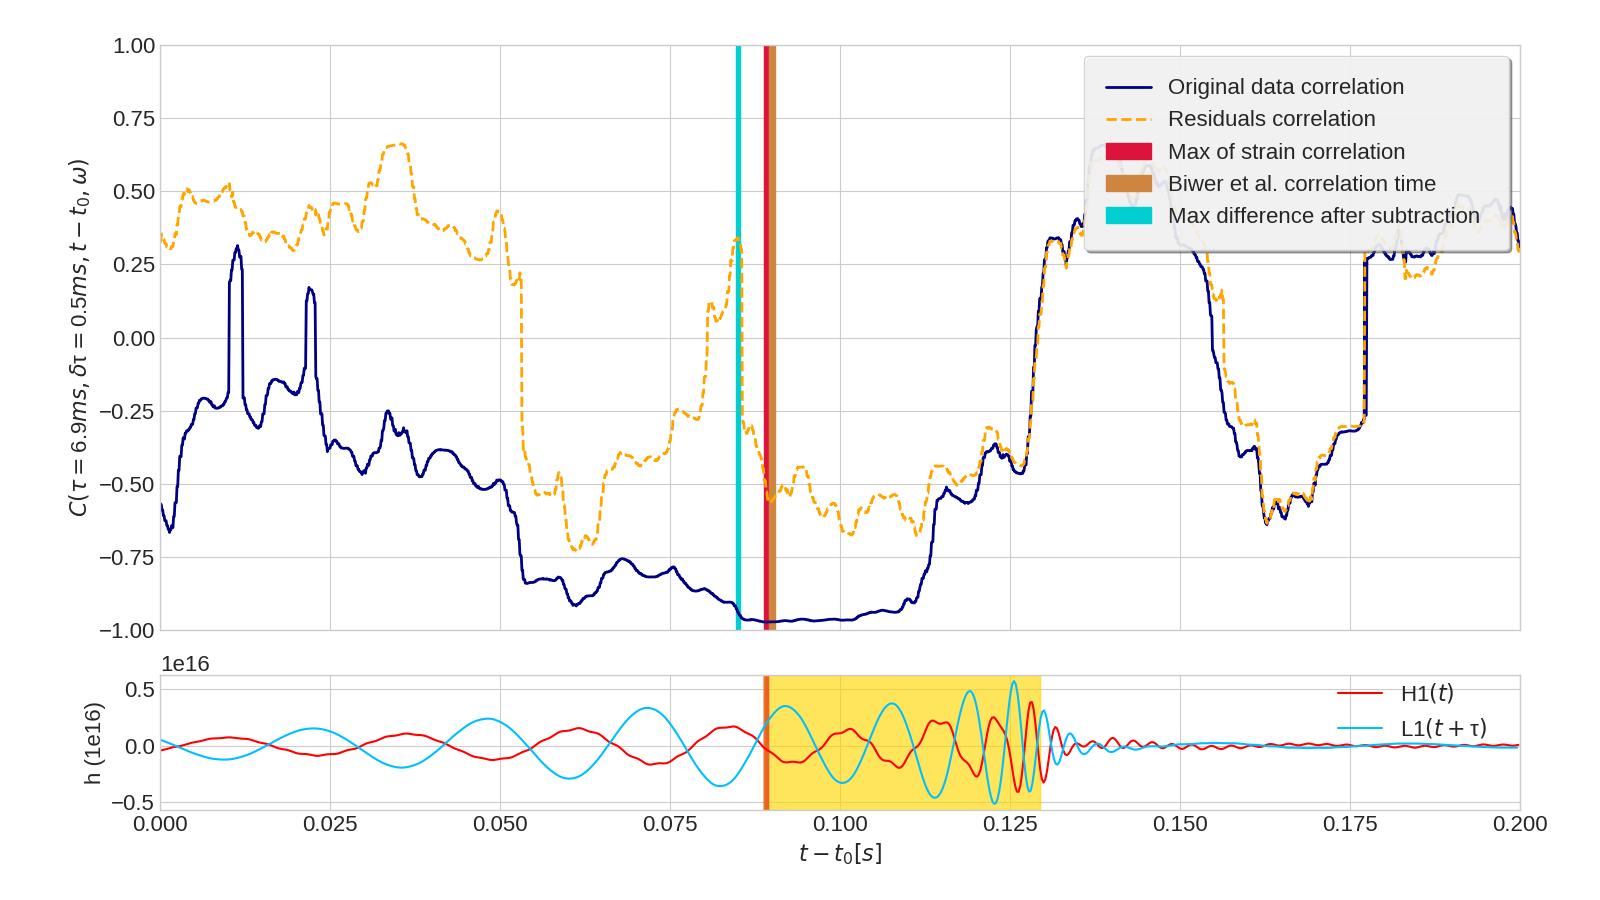

Text(0.5,0,'$t -  t_0 [s]$')

In [19]:
%matplotlib nbagg

fig = plt.figure(figsize = [16,9]) 

ax1 = fig.add_axes([0.1,0.3,0.85,0.65], xticklabels = [],ylim = (-1., 1.), xlim =(0.,0.2))
ax3 = fig.add_axes([0.1,0.1,0.85,0.15], xlim =(0.,0.2))
ax1.plot(dfcorr.Timeshift, dfcorr.SigCorr, 
         label = 'Original data correlation', color = 'navy',linewidth = 2)

ax1.plot(dfcorr.Timeshift, dfcorr.ResCorr, 
         label = 'Residuals correlation', linestyle ='--', color = 'orange',
         linewidth = 2)

ax1.axvspan((dfcorr.Timeshift[idmaxcorr]+dfcorr.Timeshift[idmaxcorr - 6
     ])/2.,(dfcorr.Timeshift[idmaxcorr]+dfcorr.Timeshift[idmaxcorr +6])/2., 
     0.0, 1, label = 'Max of strain correlation', color = 'crimson')

# Use the following axvspan only for GW150914

ax1.axvspan(tc- basetime - 0.0004,
            tc - basetime + 0.0004, 0.0, 1,
             label = 'Biwer et al. correlation time',
             color = 'peru')

ax1.axvspan((dfcorr.Timeshift[idmaximp]+dfcorr.Timeshift[idmaximp-6])/2.,
            (dfcorr.Timeshift[idmaximp]+dfcorr.Timeshift[idmaximp +6])/2., 0.0, 1,
             label = 'Max difference after subtraction ',
             color = 'darkturquoise')

ax1.legend(loc = 1,fancybox =True, frameon = True,framealpha = 0.85, borderpad = 1,shadow = 'True')
ax1.set_xlim(0.,0.2)
ax1.set_ylabel(r'$C(\tau = $' + str(timedl * 1000) + '$ ms, \delta $'+u'τ'+'$ = $' + str(tdlerr*1000) + '$ ms, t -  t_0, \omega)$')
for (ifo,h) in sorted(whtd_wave.items()):
         if(ifo == 'H1'):
             h = h.time_slice(tstart,tend)
             ax3.plot(h.sample_times - basetime,h, label = ifo+'$(t)$', color ='red')
         else:
             h = h.time_slice(tstart-timedl,tend -timedl)
             ax3.plot(h.sample_times - basetime + timedl,h, label = ifo+'$(t + $'+u'τ' +'$ )$', 
             color = 'deepskyblue')
        
         ax3.axvspan((dfcorr.Timeshift[idmaxcorr]+dfcorr.Timeshift[idmaxcorr - 6])/2.,
                     (dfcorr.Timeshift[idmaxcorr]+dfcorr.Timeshift[idmaxcorr +6])/2., 
                      0.0, 1, color = 'crimson')
         ax3.axvspan((dfcorr.Timeshift[idmaxcorr]+dfcorr.Timeshift[idmaxcorr  -6])/2.,
                     (dfcorr.Timeshift[idmaxcorr]+dfcorr.Timeshift[idmaxcorr +6])/2.+ window, 
                      0.0, 1, color = 'gold', alpha=0.4)

ax3.set_xlim(0.,0.2)
ax3.autoscale(axis='y')
#ax3.set_ylabel('h (1e17)') # Use this setup only for GW151226, use the bottom one for the rest
ax3.set_ylabel('h (1e16)')
ax3.legend(loc = 1,fancybox =True,  borderpad = 1,shadow = True, bbox_to_anchor=(0.8,1,0.2,0.2))
ax3.set_xlabel(r'$t -  t_0 [s]$'.format(basetime))

The figure obtained may be saved by running :

In [20]:
fig.savefig('GW150914CorrVsTime.png',dpi = 200)
#fig.savefig('GW151012CorrVsTime.png',dpi = 200)
#fig.savefig('GW151226CorrVsTime.png',dpi = 200)
#fig.savefig('GW170104CorrVsTime.png',dpi = 200)